The data we use in this project is from [PhysioNet 2016 Challenge](https://physionet.org/content/challenge-2016/1.0.0/)

# Importing Libraries

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 


import librosa
import librosa.display
from IPython.display import Audio 
from IPython.core.display import display

import tensorflow as tf
import tensorflow_io as tfio



import warnings
warnings.filterwarnings('ignore')

# Functions

In [18]:
def get_wave(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)  ## The output needs to be decoded by using the next line
    ## Next line gives a numerical values of an audio file and the output needs to be reshaped
    # Decode wav (tensors by channels) ## Desired Channel = 1 means not sterio type
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) 
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# Data Set

In [19]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}
df_ref = {}

def file_path(audio_name):
    return f"../train_test_original/training-{audio_name[0]}/{audio_name}.wav"

for key in training:
    
    path = "../train_test_original/"+training[key]+"/REFERENCE-SQI.csv"
    df_ref[key] = pd.read_csv(path, header=None).rename(columns = {
       0:"name", 1:"num_1", 2:"num_2"})
    df_ref[key]["path"] = df_ref[key]["name"].apply(lambda x: file_path(x))

In [20]:
records = {}
df_records = {}


for key in training:
    
    all_rec = "../train_test_original/"+training[key]+"/RECORDS"
    normal  = "../train_test_original/"+training[key]+"/RECORDS-normal"
    abnormal= "../train_test_original/"+training[key]+"/RECORDS-abnormal"

    all_recs = {}
    normals = {}
    abnormals = {}

    with open(all_rec, "r") as rec:
        all_rec = rec.readlines()
        for line in all_rec:
            all_recs[line[:-1]] = 0


    with open(normal, "r") as n:
        n_recs = n.readlines()
        for line in n_recs:
            normals[line[:-1]] = "normal"
        
    with open(abnormal, "r") as ab:
        ab_recs = ab.readlines()
        for line in ab_recs:
            abnormals[line[:-1]] = "abnormal"     
        
        

    for item in all_recs:
        if item in list(normals.keys()):
            all_recs[item] = normals[item]
        else:
            all_recs[item] = abnormals[item]
            
    records[key] = all_recs
    df_records[key] = pd.DataFrame(list(records[key].items()),
                            columns = ['Audio','target'])

In [21]:
sum = 0
for item in df_records:
    print(item, len(df_records[item]))
    sum += len(df_records[item])
    
print("\n",sum)   

a 409
b 490
c 31
d 55
e 2141
f 114

 3240


In [22]:
df_train = pd.DataFrame()
all_records = pd.DataFrame()
all_ref = pd.DataFrame()

all_records = df_records["a"]
all_ref     = df_ref["a"]

for item in ["b", "c", "d", "e", "f"]:
    all_records = pd.concat([all_records, df_records[item]], axis = 0)
    all_ref     = pd.concat([all_ref, df_ref[item]], axis = 0)

df_train = pd.concat([all_ref, all_records], axis = 1)
df_train.drop(columns = ["num_1","Audio"], inplace = True, axis = 1)
# df_train = df_train.sample(frac = 1)


df_train.to_csv('df_train.csv')

In [23]:
df_train.head()

,name,num_2,path,target
0,a0001,1,../train_test_original/training-a/a0001.wav,abnormal
1,a0002,1,../train_test_original/training-a/a0002.wav,abnormal
2,a0003,1,../train_test_original/training-a/a0003.wav,abnormal
3,a0004,1,../train_test_original/training-a/a0004.wav,abnormal
4,a0005,1,../train_test_original/training-a/a0005.wav,abnormal


In [24]:
print("Duplications:\n")
print( df_train.duplicated().sum())
print("\nMissing Values:\n")
print(df_train.isna().sum())
print("\nTarget Values:\n")
print( df_train.target.value_counts(normalize = True))

Duplications:

0

Missing Values:

name      0
num_2     0
path      0
target    0
dtype: int64

Target Values:

normal      0.794753
abnormal    0.205247
Name: target, dtype: float64


# Some Visualizations

Getting the length of each audio file and add it to the df_train

In [25]:
# df_train["audio_length"] = df_train["path"].apply(lambda x: len(get_wave(x)))

In [26]:
# df_train["audio_length"].plot(kind = "hist");

In [27]:
# print("max: ", df_train["audio_length"].max())
# print("min: ", df_train["audio_length"].min())
# print("mean: ", df_train["audio_length"].mean())
# print("median: ", df_train["audio_length"].median())

# Getting Spectrogram of the Audio Files 

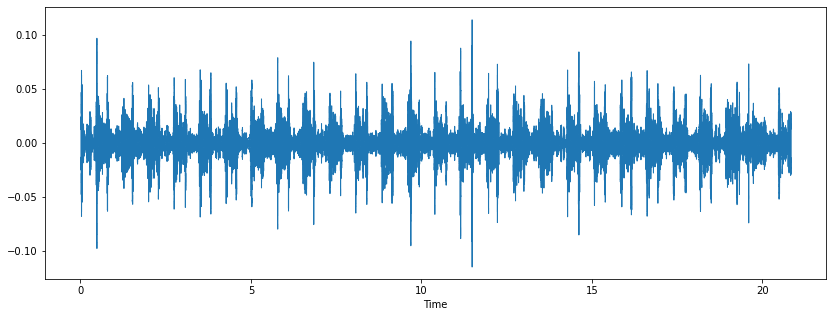

In [66]:
### Example
example_id = 1
audio_path = df_train["path"].iloc[example_id]
audio_name = df_train["name"].iloc[example_id]
fig_path = "../spectrograms/" +  audio_name

SAMPLE_RATE = 44000
x, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr);





In [67]:
display(Audio(audio_path, rate = sr, autoplay=True))


The following code is from [here](https://www.tutorialspoint.com/how-to-save-a-librosa-spectrogram-plot-as-a-specific-sized-image)

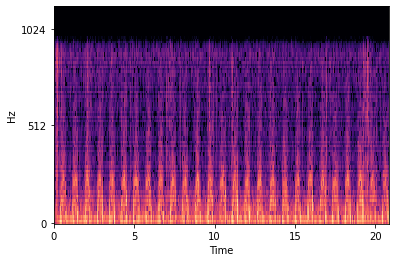

In [68]:
hl = 512 # number of samples per time-step in spectrogram
hi = 100 # Height of image
wi = 384 # Width of image
fmax = 1200

S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=hi, fmax=fmax,n_fft=2048,
hop_length=hl)

# S = np.log(S + 1e-10)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fmax)



## Create a new figure, plot into it, then close it so it never gets displayed
## Use plt.ioff() and plt.close() at the end.

# plt.ioff()

plt.savefig(fig_path + ".png")
# plt.close()


# plt.show()